In [85]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from statsmodels.tsa.stattools import adfuller

from datetime import datetime
from datetime import timedelta
from pandas.plotting import register_matplotlib_converters
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.arima.model import ARIMA
register_matplotlib_converters()
from time import time

In [86]:
df = pd.read_csv("./brent_data.csv")
df

,Date,Open,High,Low,Close
0,1/4/2000,23.90,24.70,23.89,24.39
1,1/5/2000,24.25,24.37,23.70,23.73
2,1/6/2000,23.55,24.22,23.35,23.62
3,1/7/2000,23.57,23.98,23.05,23.09
4,1/10/2000,23.04,23.78,23.04,23.73
...,...,...,...,...,...
6227,03/25/2024,85.07,86.51,84.79,86.08
6228,03/26/2024,86.20,86.42,85.19,85.63
6229,03/27/2024,85.17,85.70,84.58,85.41
6230,03/28/2024,85.73,87.07,85.50,87.00


In [87]:
# Convert 'Date' column to datetime
df['Date'] = pd.to_datetime(df['Date'])
# # Set 'Date' column as the index
df.set_index('Date', inplace=True)

In [88]:
series = df["Close"]
series

Date
2000-01-04    24.39
2000-01-05    23.73
2000-01-06    23.62
2000-01-07    23.09
2000-01-10    23.73
              ...  
2024-03-25    86.08
2024-03-26    85.63
2024-03-27    85.41
2024-03-28    87.00
2024-03-29    87.00
Name: Close, Length: 6232, dtype: float64

In [89]:
# ADF Test
def perform_adf_test(series):
    result = adfuller(series)
    print('ADF Statistic: %f' % result[0])
    print('p-value: %f' % result[1])

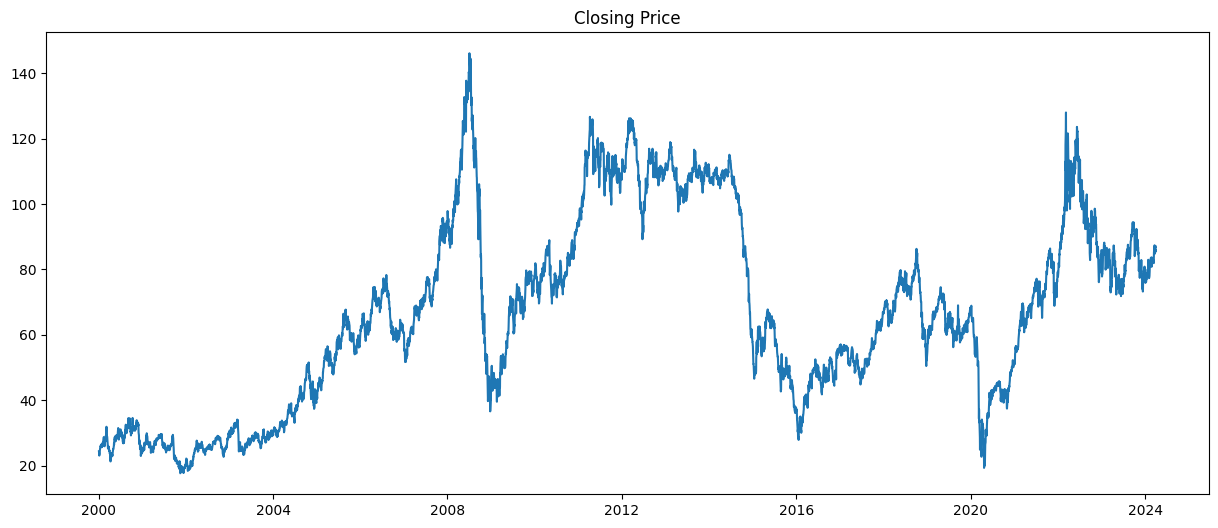

In [90]:
plt.figure(figsize=(15, 6))
plt.plot(series, linestyle='-')
plt.title("Closing Price")
plt.show()

In [91]:
perform_adf_test(series)

ADF Statistic: -2.279120
p-value: 0.178791


In [92]:
first_diff = series.diff().dropna()
first_diff

Date
2000-01-05   -0.66
2000-01-06   -0.11
2000-01-07   -0.53
2000-01-10    0.64
2000-01-11    0.89
              ... 
2024-03-25    1.25
2024-03-26   -0.45
2024-03-27   -0.22
2024-03-28    1.59
2024-03-29    0.00
Name: Close, Length: 6231, dtype: float64

ADF Statistic: -16.178956
p-value: 0.000000


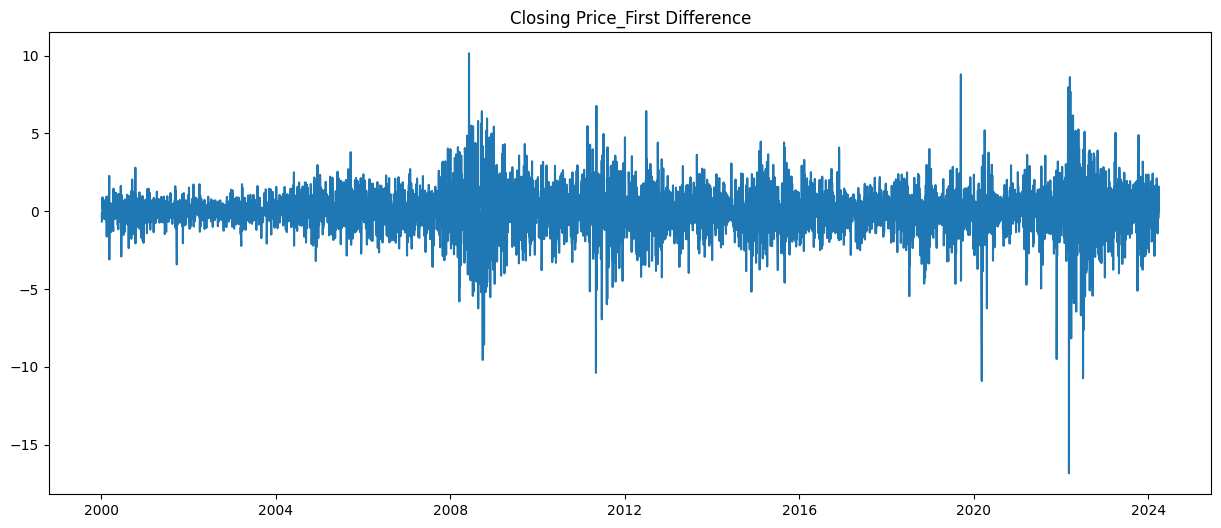

In [93]:
plt.figure(figsize=(15, 6))
plt.title("Closing Price_First Difference")
plt.plot(first_diff, linestyle='-')
perform_adf_test(first_diff)

<BarContainer object of 15 artists>

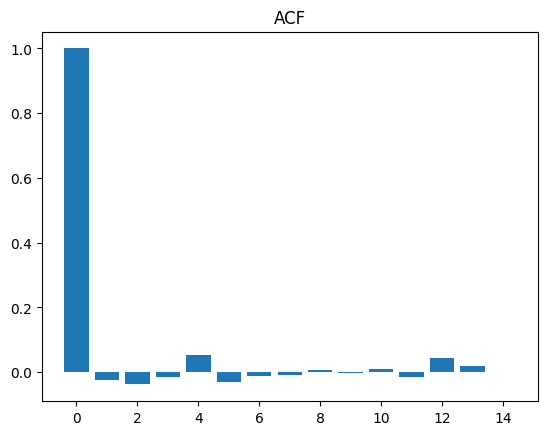

In [94]:
num_lags = 15
acf_vals = acf(first_diff)
plt.title("ACF")
plt.bar(range(num_lags), acf_vals[:num_lags])
# MA(2) or MA(4)

<BarContainer object of 15 artists>

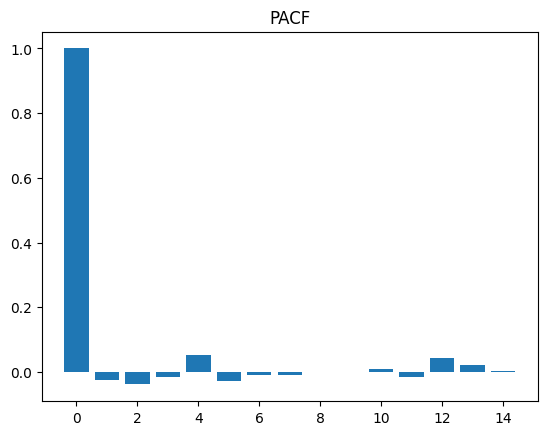

In [95]:
pacf_vals = pacf(first_diff)
plt.title("PACF")
plt.bar(range(num_lags), pacf_vals[:num_lags])
# AR(2) or AR(4)

In [96]:
train_end = datetime(2023,3,1)
test_end = datetime(2024,3,1)

train_data = first_diff[:train_end]
test_data = first_diff[train_end + timedelta(days=1):test_end]

5950

In [99]:
# define model ARMA(2, 2)
model = ARIMA(train_data, order=(2,0, 2))

/Users/zhiyichen/miniconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/zhiyichen/miniconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/zhiyichen/miniconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


In [100]:
#fit the model
start = time()
model_fit = model.fit()
end = time()
print('Model Fitting Time:', end - start)

Model Fitting Time: 3.888054847717285


In [101]:
#summary of the model
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                 5950
Model:                 ARIMA(2, 0, 2)   Log Likelihood              -10669.978
Date:                Thu, 25 Apr 2024   AIC                          21351.957
Time:                        10:06:27   BIC                          21392.104
Sample:                             0   HQIC                         21365.904
                               - 5950                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0100      0.019      0.528      0.597      -0.027       0.047
ar.L1          0.1574      0.006     24.324      0.000       0.145       0.170
ar.L2         -0.9816      0.006   -155.876      0.0

In [84]:
#get prediction start and end dates
pred_start_date = test_data.index[0]
pred_end_date = test_data.index[-1]
pred_end_date

Timestamp('2024-03-01 00:00:00')

In [115]:
#get the predictions and residuals
predictions = model_fit.predict(start=len(train_data), end=len(test_data)+len(train_data)-1)
residuals = test_data - predictions

/Users/zhiyichen/miniconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/zhiyichen/miniconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


In [114]:
test_data


Date
2023-03-02    0.44
2023-03-03    1.08
2023-03-06    0.35
2023-03-07   -2.89
2023-03-08   -0.63
              ... 
2024-02-26    0.87
2024-02-27    0.99
2024-02-28   -0.51
2024-02-29   -0.24
2024-03-01    1.64
Name: Close, Length: 261, dtype: float64

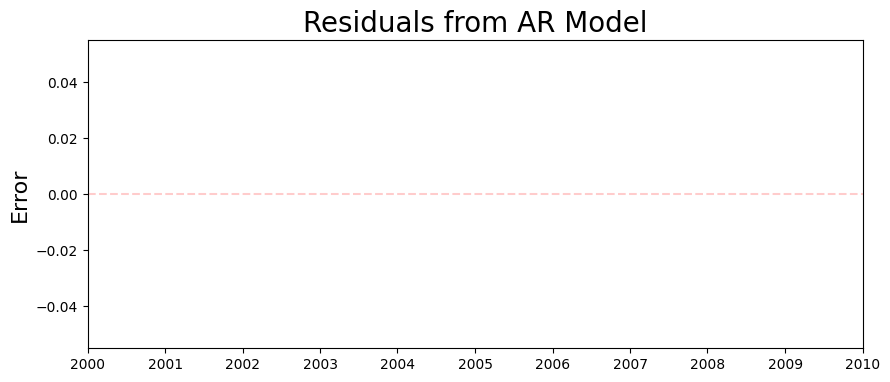

In [111]:
plt.figure(figsize=(10,4))
plt.plot(residuals)
plt.title('Residuals from AR Model', fontsize=20)
plt.ylabel('Error', fontsize=16)
plt.axhline(0, color='r', linestyle='--', alpha=0.2)